In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from rfest import splineLG, splineLNP, splineLNLN
from rfest import build_design_matrix, get_spatial_and_temporal_filters

# Load Data

In this notebook, we use Salamander RGC data from [(Maheswaranathan et. al. 2018)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006291). You can download it [here](https://github.com/baccuslab/inferring-hidden-structure-retinal-circuits/blob/master/rgc_whitenoise.h5).

In [2]:
datapath = '../../data/rgc_whitenoise.h5' # change this to where you save the file
with h5py.File(datapath, 'r') as f:
    print(f.keys())
    stimulus = np.array(f['stimulus'])
    rates = np.array(f['firing_rates'])
    spikes = np.array(f['spike_counts'])
    time = np.array(f['time'])

<KeysViewHDF5 ['firing_rates', 'spike_counts', 'stimulus', 'time']>


In [3]:
stim_dim = stimulus.shape[0]
hist_dim = 40
dims = [hist_dim, stim_dim]

dt = 0.01
R = 1

cell_id = 7

X = build_design_matrix(stimulus.T, dims[0])
y_spike = spikes[cell_id]
y_rate = rates[cell_id]

df = [9, 26] # [df_t, df_x]

# Linear-Gaussian Model

Initialzing `splineLG` and others, STA (`w_sta`) and spline-based maximum likelihood (`w_spl`) will be calculated automatically. Calculating MLE (`w_mle`) is optional, as it is unpractical to do everytime for large dataset. By calling `fit()`, the optimized RF (`w_opt`) is computed with regularization, where flag `alpha` is the balance between L1 and L2, flag `beta` is the overall penalty weight.

In [4]:
lg = splineLG(X, y_rate, dims=dims, df=df, smooth='cc', compute_mle=True) # try cyclic cubic spline
lg.fit(num_iters=100, beta=0.05, verbal=30, step_size=0.1)

/Users/ziweih/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Iter	Cost	
0	295.099	
30	275.064	
60	272.386	
90	272.366	
Stop: reached 100 steps, final cost=272.36454.


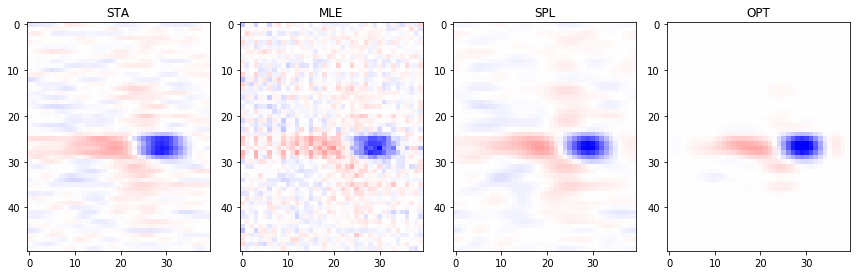

In [5]:
def plot_single_filter(obj, vmin=-0.2, vmax=0.2):
    
    def norm(x):
        return x / np.linalg.norm(x)
    
    dims = obj.dims
    sta = norm(obj.w_sta).reshape(dims).T
    spl = norm(obj.w_spl).reshape(dims).T
    try:
        mle = norm(obj.w_mle).reshape(dims).T
    except:
        mle = np.zeros_like(sta)
    try:
        opt = norm(obj.w_opt).reshape(dims).T
    except:
        opt = np.zeros_like(sta)
    
    fig, ax = plt.subplots(1, 4, figsize=(12, 4))
    ax[0].imshow(sta, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)
    ax[0].set_title('STA')
    
    ax[1].imshow(mle, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)

    if (mle == 0).all():
        ax[1].axis('off')
        ax[1].set_title('MLE (not computed)')
    else:
        ax[1].set_title('MLE')
        
    ax[2].imshow(spl, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)
    ax[2].set_title('SPL')
    
    ax[3].imshow(opt, cmap=plt.cm.bwr, vmin=vmin, vmax=vmax)

    if (opt == 0).all():
        ax[3].axis('off')
        ax[3].set_title('OPT (not computed)')
    else:
        ax[3].set_title('OPT')

    fig.tight_layout()
    
plot_single_filter(lg)

# Linear-Nonlinear Poisson Model

`splineLNP` has a few extra arguments. `dt` is the refresh rate of the stimulus, `R` is the maximum firing rate. The default of nonlinearity is `softplus`, as it's more stabler than `exponential` most of the time. If a flexible nonlinearity is desired, nonlinearity can be set to `nonparametric` then followed by calling `fit_nonlinearity()`

In [6]:
lnp = splineLNP(X, y_spike, dims=dims, df=df, smooth='cc', 
                dt=dt, R=R, 
                compute_mle=True,
                nonlinearity='nonparametric')
lnp.initialize_nonlinearity(w='w_spl') # w can be 'w_sta' or 'w_spl', or an already-computed RF.
lnp.fit(num_iters=150, beta=5., step_size=0.1, verbal=20,
        fit_intercept=True, fit_nonlinearity=True) # as the cost function is not normalized
                                             # by the sample size, the good choice of lambd 
                                             # will vary from dataset to dataset. 

Iter	Cost	
0	7138.032	
20	-6554.050	
40	-8901.795	
60	-9419.466	
80	-9661.480	
100	-9825.095	
120	-9953.625	
140	-10061.945	
Stop: reached 150 steps, final cost=-10106.63642.


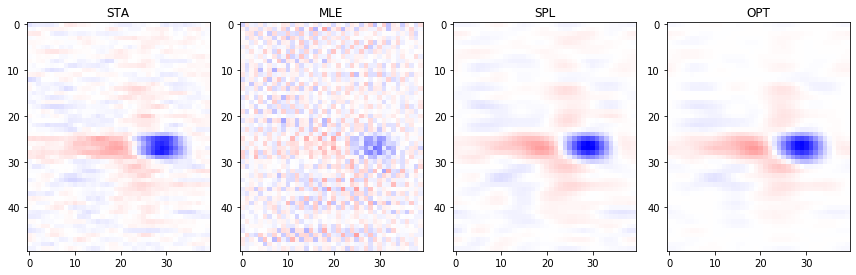

In [7]:
plot_single_filter(lnp)

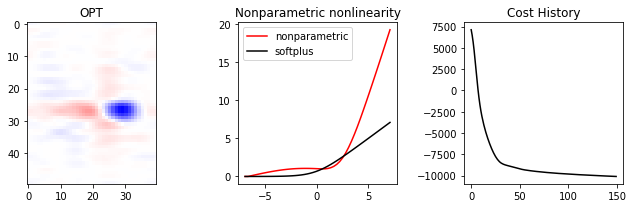

In [8]:
def plot_results(obj):
    k = obj.w_opt
    k_norm = ( k/ np.linalg.norm(k)).reshape(dims)

    fig, ax = plt.subplots(1,3, figsize=(9,3))
    ax[0].imshow(k_norm.T, cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
    ax[0].set_title('OPT')

    ax[1].plot(obj.bins, obj.fnl(obj.bins, nl='nonparametric'), 
               color='red', label='nonparametric')
    ax[1].plot(lnp.bins, lnp.fnl(lnp.bins, nl='softplus'), 
             color='black', label='softplus')
    ax[1].set_title('Nonparametric nonlinearity')
    ax[1].legend()

    ax[2].plot(obj.cost_history, color='black')
    ax[2].set_title('Cost History')

    fig.tight_layout()
    
plot_results(lnp)

# Subunit Model

For estimating subunits, it'd be a good idea to do a spike-triggered covariance analysis first, so that we will have a rough idea of how many subunits to estimate (let's say it's a lower bound), and can fit a flexible nonlinearity using STC filters. The latter is actually quite interesting, as assuming different nonlinearities, LNLN can retrieve different subunits.

In [9]:
lnln = splineLNLN(X, y_spike, dims=dims, df=df, smooth='cc', dt=dt, R=R, 
            filter_nonlinearity='nonparametric', output_nonlinearity='softplus')

In [10]:
lnln.initialize_nonlinearity(w='w_spl')
lnln.fit(num_iters=300, num_subunits=4, beta=5., verbal=30,
        fit_intercept=True, step_size=0.1)

Iter	Cost	
0	2200.378	
30	-4826.963	
60	-7023.925	
90	-8109.160	
120	-8727.473	
150	-9328.232	
180	-9840.101	
210	-10152.740	
240	-10361.318	
270	-10513.106	
Stop: reached 300 steps, final cost=-10613.84020.


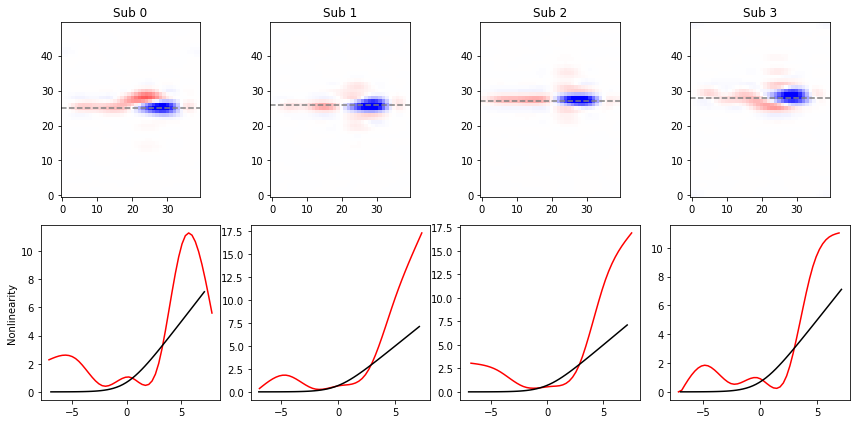

In [11]:
def plot_results(obj):
    
    sRF_min = []
    for i in range(4):
        sRF, tRF = get_spatial_and_temporal_filters(obj.w_opt[:, i], dims)
        sRF_min.append(sRF.argmin())
        
    sRF_order = np.argsort(sRF_min)
    
    w_opt = obj.w_opt[:, sRF_order]
    sRF_min = np.array(sRF_min)[sRF_order]

    fig, ax = plt.subplots(2,4, figsize=(12,6))
    
    for i in range(4):
        w = w_opt[:, i]
        w_norm = ( w/ np.linalg.norm(w)).reshape(dims)
        ax[0, i].imshow(w_norm.T, origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
        ax[0, i].set_title(f'Sub {i}')
        ax[0, i].axhline(sRF_min[i], color='grey', linestyle='--')
        
        obj.initialize_nonlinearity(w=w_opt[:, i])
        ax[1, i].plot(obj.bins, obj.fnl(obj.bins, nl='nonparametric'), 
                      color='red', label='nonparametric')
        ax[1, i].plot(lnp.bins, lnp.fnl(lnp.bins, nl='softplus'), 
             color='black', label='softplus')      
    ax[1, 0].set_ylabel('Nonlinearity')

    fig.tight_layout()
    
plot_results(lnln)